A companhia farmacêutica Lusa_Med detém os direitos sobre dez projetos I&D, P1, …, P10, e pretende iniciá-los na tentativa de desenvolver novos medicamentos para o tratamento de dez tipos específicos de doenças. Cada projeto necessita de um coordenador distinto para o liderar e, atendendo à exigência dos projetos, cada coordenador só poderá liderar um só projeto. A Lusa_Med já selecionou dez cientistas seniores, C1, …, C10, e pretende saber como deve alocar os cientistas aos projetos. Para o efeito, a companhia elaborou uma tabela com a aptidão de cada cientista para liderar cada um dos projetos (medida na escala 0-100):

In [11]:
import numpy as np
from fslash.core import pipe
from pampy import match, _
from dataclasses import dataclass as dc
from copy import deepcopy as copy
from pandas import DataFrame
showLog = True
table = np.array([
    [ 70,  65,  55,  50,  90,  67,  80,  62, 100,  85],
    [ 74,  83,  54,  60, 100,  75,  50,  76,  82,  45],
    [ 71,  87,  66,  58,  74,  81,  48,  52, 100,  64],
    [ 50,  89,  78,  63,  51,  40,  48, 100,  68,  75],
    [100,  66,  83,  77,  54,  58,  93,  89,  53,  48],
    [ 80,  55,  70,  65,  94,  47,  60,  88,  73,  60],
    [ 87,  63,  90,  79,  47,  77,  90,  76,  85,  90],
    [ 67,  95, 100,  40,  70,  54,  70, 100,  65,  57],
    [ 90,  45,  88,  48,  65,  68,  80,  46,  71,  67],
    [ 67,  77,  50,  60, 100,  70,  80,  60,  65,  70]
])
table

array([[ 70,  65,  55,  50,  90,  67,  80,  62, 100,  85],
       [ 74,  83,  54,  60, 100,  75,  50,  76,  82,  45],
       [ 71,  87,  66,  58,  74,  81,  48,  52, 100,  64],
       [ 50,  89,  78,  63,  51,  40,  48, 100,  68,  75],
       [100,  66,  83,  77,  54,  58,  93,  89,  53,  48],
       [ 80,  55,  70,  65,  94,  47,  60,  88,  73,  60],
       [ 87,  63,  90,  79,  47,  77,  90,  76,  85,  90],
       [ 67,  95, 100,  40,  70,  54,  70, 100,  65,  57],
       [ 90,  45,  88,  48,  65,  68,  80,  46,  71,  67],
       [ 67,  77,  50,  60, 100,  70,  80,  60,  65,  70]])

a) Uma solução admissível é uma solução que satisfaz as condições presupostas do problema. Portanto para este problema, qualquer solução que admite cada cientista a cada projetos (sendo que há 10 cientistas e 10 projetos) será uma solução admissível.

b) Uma possível heurística contrutiva seria admitir como lider do projeto $i$ o cientista cujo número está associado, $i$, $i = [1 .. 10]$. Ou seja, $C_1$ será lider de $P_1$, $C_2$ de $P_2$, e assim sucessivamente. Esta heurística, embora produzindo uma solução admissível, não é interessante para a **Lusa_med**, sendo que é equivalente a uma heurística que escolhe os líderes de forma aleatória (sem reposição). Portanto, uma heurística construtiva alternativa seria alocar para o cientista $i$ o projeto em que este tem a sua melhor aptidão, entre as ainda não alocadas ainda, $i =[1 .. 10]$. Ou seja, $C_1 \rightarrow P_9$, $C_2 \rightarrow P_5$, e assim sucesivamente.

In [12]:
@dc
class Project:
    index: int
    aptidao: int
@dc
class Cientista:
    index: int
    aptidoes: np.ndarray[int]
    projetoAssociado: Project = None
    projetos: list[Project]   = None
    def __post_init__(self):
        self.projetos = [Project(i+1, apt) for i, apt in enumerate(self.aptidoes)]
    def __str__(self):
        if self.projetoAssociado is not None:
            return f"C_{self.index}: P_{self.projetoAssociado.index} (Aptidão de {self.projetoAssociado.aptidao})"
        else:
            return f"C_{self.index} sem projeto associado"
    def reset(self):
        self.projetoAssociado = None
    def __getitem__(self, ind):
        return self.projetos[ind-1]
@dc
class Cientistas:
    matrix: np.ndarray[int, int]
    cientistas: list[Cientista] = None #will be overwriten
    def __post_init__(self):
        self.cientistas = []
        for i, row in enumerate(self.matrix):
            self.cientistas.append(Cientista(i+1, row))
    def __getitem__(self, indexDoCientista: int, indexDaAptidao: int = None) -> Cientista:
        if indexDaAptidao is None: return self.cientistas[indexDoCientista - 1]
        else: return self.cientistas[indexDoCientista - 1].aptidoes[indexDaAptidao - 1]
    def get(self, indexDoCientista) -> Cientista:
        return self[indexDoCientista]
    def __str__(self):
        ret = "Cientistas e os seus projetos associados: \n"
        for c in self.cientistas:
            ret += "  " + str(c) + "\n"
        ret += f"  Soma das aptidões: {self.getSum()}"
        return ret
    def reset(self):
        self.__post_init__()
    def __iter__(self):
        return iter(self.cientistas)
    def getSum(self):
        return sum([cient.projetoAssociado.aptidao for cient in self.cientistas if cient.projetoAssociado is not None])
    @property
    def aptidaoTotal(self):
        return self.getSum()
    def __len__(self):
        return len(self.cientistas)
    def tradeProject(self, cientista1: int | Cientista, cientista2: int | Cientista):
        if type(cientista1) is int: cientista1 = self.get(cientista1)
        if type(cientista2) is int: cientista2 = self.get(cientista2)
        # standart trade isn't good because the projects cientist based, that is its aptidao is based on the cientist
        cient1ProjInd = cientista1.projetoAssociado.index
        cient2ProjInd = cientista2.projetoAssociado.index
        cientista1.projetoAssociado = cientista1[cient2ProjInd]
        cientista2.projetoAssociado = cientista2[cient1ProjInd]
    def __eq__(self, other):
        if len(self) != len(other): return False
        for i in range(len(self)+1):
            if self[i].projetoAssociado.index != other[i].projetoAssociado.index:
                return False
        return True
def log(*args, **kwargs):
    if showLog:
        print(*args, **kwargs)
cientistas = Cientistas(table)
/print cientistas

Cientistas e os seus projetos associados: 
  C_1 sem projeto associado
  C_2 sem projeto associado
  C_3 sem projeto associado
  C_4 sem projeto associado
  C_5 sem projeto associado
  C_6 sem projeto associado
  C_7 sem projeto associado
  C_8 sem projeto associado
  C_9 sem projeto associado
  C_10 sem projeto associado
  Soma das aptidões: 0


In [13]:
# c)
cientistas.reset()
pool = pipe(range(1,11), list)
def getMax(cient) -> Project:
    log("Cientista", cient.index)
    log("  Pool:", pool)
    projetos = [cient[projInd] for projInd in pool]
    maxObj   = max(projetos, key=lambda proj: proj.aptidao)
    log("  Max:", maxObj)
    return maxObj
    
for i, cientista in enumerate(cientistas):
    maxApt = getMax(cientista)
    cientista.projetoAssociado = maxApt
    pool.remove(maxApt.index)

print(cientistas)

Cientista 1
  Pool: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Max: Project(index=9, aptidao=100)
Cientista 2
  Pool: [1, 2, 3, 4, 5, 6, 7, 8, 10]
  Max: Project(index=5, aptidao=100)
Cientista 3
  Pool: [1, 2, 3, 4, 6, 7, 8, 10]
  Max: Project(index=2, aptidao=87)
Cientista 4
  Pool: [1, 3, 4, 6, 7, 8, 10]
  Max: Project(index=8, aptidao=100)
Cientista 5
  Pool: [1, 3, 4, 6, 7, 10]
  Max: Project(index=1, aptidao=100)
Cientista 6
  Pool: [3, 4, 6, 7, 10]
  Max: Project(index=3, aptidao=70)
Cientista 7
  Pool: [4, 6, 7, 10]
  Max: Project(index=7, aptidao=90)
Cientista 8
  Pool: [4, 6, 10]
  Max: Project(index=10, aptidao=57)
Cientista 9
  Pool: [4, 6]
  Max: Project(index=6, aptidao=68)
Cientista 10
  Pool: [4]
  Max: Project(index=4, aptidao=60)
Cientistas e os seus projetos associados: 
  C_1: P_9 (Aptidão de 100)
  C_2: P_5 (Aptidão de 100)
  C_3: P_2 (Aptidão de 87)
  C_4: P_8 (Aptidão de 100)
  C_5: P_1 (Aptidão de 100)
  C_6: P_3 (Aptidão de 70)
  C_7: P_7 (Aptidão de 90)
  C_8: P_10 (Ap


```mermaid
flowchart
    C1 -->|100| P9
    C2 -->|100| P5
    C3 -->|87| P2
    C4 -->|100| P8
    C5 -->|100| P1
    C6 -->|70| P3
    C7 -->|90| P7
    C8 -->|57| P10
    C9 -->|68| P6
    C10 -->|60| P4
```

d) Uma estrutura de vizinhança para este problema pode ser definida como a troca de projetos entre dois cientistas. Ou seja, dado dois cientistas $C_i$ e $C_j$ com projetos associados $C_i \rightarrow P_k$ e $C_j \rightarrow P_l$, a troca de projetos entre estes dois cientistas resulta em $C_i \rightarrow P_l$ e $C_j \rightarrow P_k$, $i,k \in [1 .. 9]$, $j,l \in [2 .. 10]$, $i \neq j$, $k \neq l$. De forma a garantir que todos os cientistas trocam de projeto em pelo menoz 2 vizinhos, é necessário fazer mais uma solução vizinha, que consiste em trocar a primeira com a última, ou seja, $C_1 \rightarrow P_{k}$ e $C_{10} \rightarrow P_l$.

In [14]:
# d)
def getVizinhanca(cientistas: Cientistas) -> list[Cientistas]:
    vizinhanca = []
    for i in range(1, len(cientistas)): # [1:9]
        vizinho = copy(cientistas)
        vizinho.tradeProject(i, i+1)
        vizinhanca.append(vizinho)
    return vizinhanca

e) Uma solução vizinha da apresentada na alínea c) é a seguinte:

```mermaid
flowchart
    C1 -->|90| P5
    C2 -->|82| P9
    C3 -->|87| P2
    C4 -->|100| P8
    C5 -->|100| P1
    C6 -->|70| P3
    C7 -->|90| P7
    C8 -->|57| P10
    C9 -->|68| P6
    C10 -->|60| P4
```

In [15]:
# e)
V = getVizinhanca(cientistas)
print(V[0])

Cientistas e os seus projetos associados: 
  C_1: P_5 (Aptidão de 90)
  C_2: P_9 (Aptidão de 82)
  C_3: P_2 (Aptidão de 87)
  C_4: P_8 (Aptidão de 100)
  C_5: P_1 (Aptidão de 100)
  C_6: P_3 (Aptidão de 70)
  C_7: P_7 (Aptidão de 90)
  C_8: P_10 (Aptidão de 57)
  C_9: P_6 (Aptidão de 68)
  C_10: P_4 (Aptidão de 60)
  Soma das aptidões: 804


f) A lista tabu é uma lista de soluções que não podem ser visitadas durante um determinado número de iterações. A lista tabu é utilizada para evitar que o algoritmo de pesquisa tabu não visite soluções visitadas recentemente, de forma a o algoritmo não ficar preso num máximo local não global. A lista precisa de um valor para a sua dimensão, sendo que uma dimensão demasiado alta pode fazer com que o algoritmo não visite soluções que poderiam ser melhores, com uma lista de tabu diferente, e um valor demasiado pequeno poderá fazer co mque o algorítmo não saia do máximo local. Este conceito é designado de tempo de permanência. Para este problema, vamos tentar vários valores de dimensão da lista tabu, de forma a encontrar o melhor valor para a mesma.

In [16]:
tabu_dim = [2, 5, 10, 15, 30, 50, 100]

g) A primeira solução iria ser adicionada à lista tabu, para a segunda não a visitar novamente, independentemente do seu valor de aptidão total. Ou seja,

In [17]:
tabu = [cientistas]

ou
$$
\mathbf{T}_1 = \left\{ \mathbf{S}_1 \right\} = \left\{ \left[ C_1 \rightarrow P_9, C_2 \rightarrow P_5, \dots, C_{10} \rightarrow P_4 \right] \right\}
$$
,onde $\mathbf{T}_i$ indica a lista tabu depois da iteração $i$, e $(C_j \rightarrow P_k) = f_i(C_j) = P_k$, $f_i$ sendo a função que indica o projeto associado ao cientista $C_j$ na iteração $i$.

H) Um movimento tabu é uma solução que esteja na lista tabu, ou seja, uma solução que não pode ser visitada na iteração em questão, porque foi visitada recentemente. Depois da primeira iteração, $S_1$ é um movimento tabu para a segunda iteração, porque $S_1 \in T_2$. Esta caracterízeração mantém-se durante a o tempo de permanência pré-definido, equivalente à dimensão da lista tabu.

In [18]:
# i)
def orderVizinhanca(vizinhanca: list[Cientistas]) -> list[Cientistas]:
    return sorted(vizinhanca, key=lambda vizinho: vizinho.aptidaoTotal, reverse=True)

def TabuSearch(primeira: Cientistas, tempo_perm: int, max_iter: int, minApt: int) -> Cientistas:
    tabu = []
    globalBest = localBest = copy(primeira)
    log("Primeira solução:")
    log(localBest)
    for i in range(max_iter):
        # atualizar lista tabu (no inicio pq livramo-nos do localBest cedo)
        tabu.append(localBest)
        if len(tabu) > tempo_perm:
            tabu.pop(0)

        # vizinhanca
        localBestV = pipe(getVizinhanca(localBest), orderVizinhanca)



        # escolher vizinho que não esteja na lista tabu
        for localVizinho in localBestV:
            if localVizinho not in tabu:
                localBest = localVizinho
                log(f"Melhor vizinho encontrado na iteração {i+1}:")
                log(localBest)
                break

        # Critério de Aspiração
        if localBest.aptidaoTotal > globalBest.aptidaoTotal: #excluive
            log("Critério de aspiração!")
            globalBest = copy(localBest) # copy n deve ser preciso mas é melhor

        # stop condition (iterações está no range já)
        if globalBest.aptidaoTotal >= minApt:
            log("Atingido valor mínimo de aptidão!")
            return globalBest
    log("Atingido número máximo de iterações!")
    return globalBest

print(TabuSearch(cientistas, tempo_perm=15, max_iter=100, minApt=850))

Primeira solução:
Cientistas e os seus projetos associados: 
  C_1: P_9 (Aptidão de 100)
  C_2: P_5 (Aptidão de 100)
  C_3: P_2 (Aptidão de 87)
  C_4: P_8 (Aptidão de 100)
  C_5: P_1 (Aptidão de 100)
  C_6: P_3 (Aptidão de 70)
  C_7: P_7 (Aptidão de 90)
  C_8: P_10 (Aptidão de 57)
  C_9: P_6 (Aptidão de 68)
  C_10: P_4 (Aptidão de 60)
  Soma das aptidões: 832
Melhor vizinho encontrado na iteração 1:
Cientistas e os seus projetos associados: 
  C_1: P_9 (Aptidão de 100)
  C_2: P_5 (Aptidão de 100)
  C_3: P_2 (Aptidão de 87)
  C_4: P_8 (Aptidão de 100)
  C_5: P_1 (Aptidão de 100)
  C_6: P_3 (Aptidão de 70)
  C_7: P_10 (Aptidão de 90)
  C_8: P_7 (Aptidão de 70)
  C_9: P_6 (Aptidão de 68)
  C_10: P_4 (Aptidão de 60)
  Soma das aptidões: 845
Critério de aspiração!
Melhor vizinho encontrado na iteração 2:
Cientistas e os seus projetos associados: 
  C_1: P_9 (Aptidão de 100)
  C_2: P_5 (Aptidão de 100)
  C_3: P_2 (Aptidão de 87)
  C_4: P_8 (Aptidão de 100)
  C_5: P_1 (Aptidão de 100)
  C_6: 

In [19]:
showLog = False
all = []
for i in range(1, 101):
    # tentar com todos os tempos de permanência
    all.append((i, TabuSearch(cientistas, tempo_perm=i, max_iter=100, minApt=850)))
print(f"Apitdão máxima com todos os tempos de permanência")
print(max(all, key=lambda x: x[1].aptidaoTotal)[1])

Apitdão máxima com todos os tempos de permanência
Cientistas e os seus projetos associados: 
  C_1: P_9 (Aptidão de 100)
  C_2: P_5 (Aptidão de 100)
  C_3: P_2 (Aptidão de 87)
  C_4: P_8 (Aptidão de 100)
  C_5: P_1 (Aptidão de 100)
  C_6: P_4 (Aptidão de 65)
  C_7: P_10 (Aptidão de 90)
  C_8: P_3 (Aptidão de 100)
  C_9: P_7 (Aptidão de 80)
  C_10: P_6 (Aptidão de 70)
  Soma das aptidões: 892


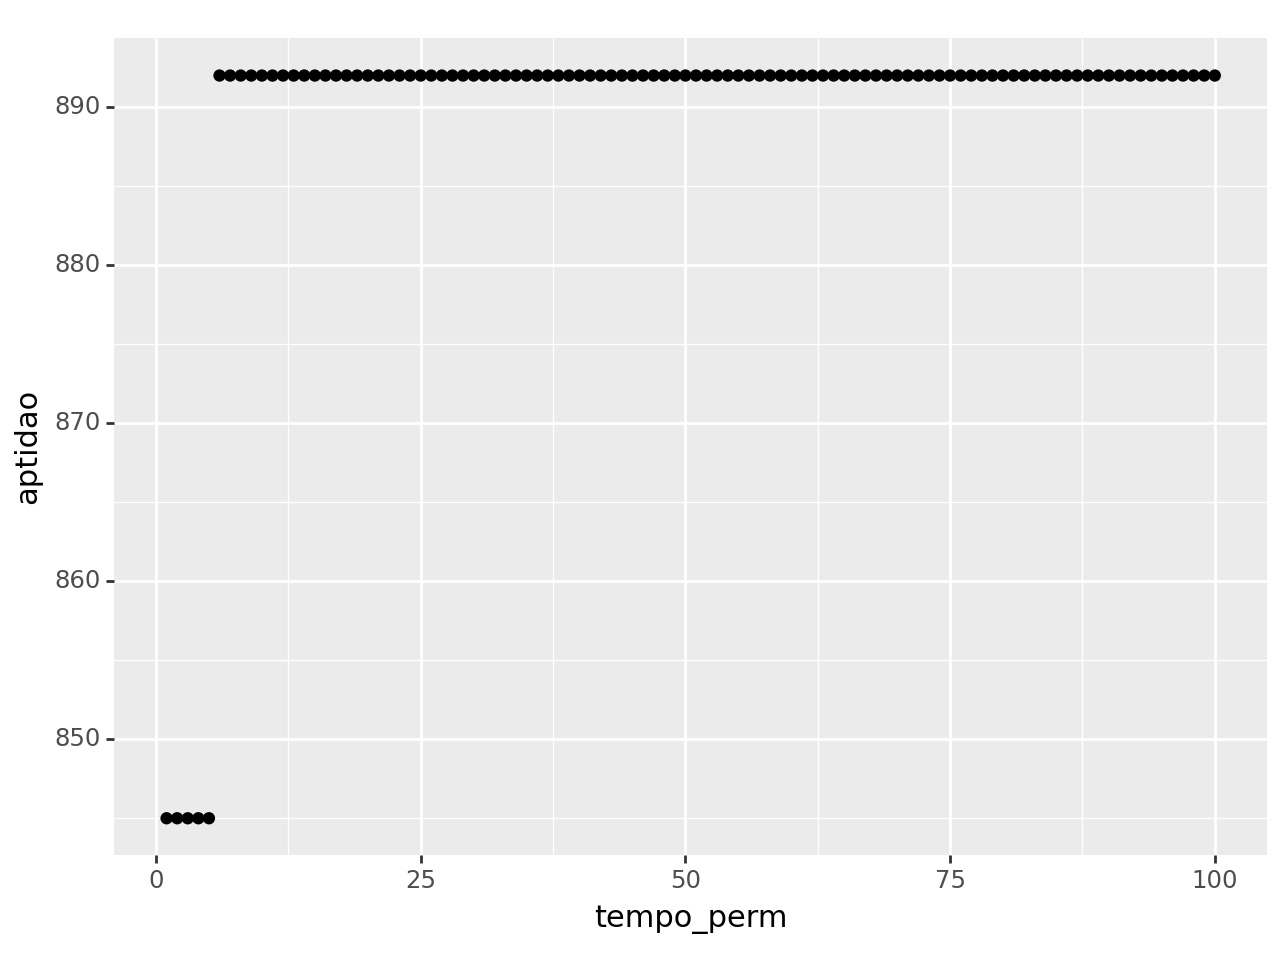

<Figure Size: (640 x 480)>

In [20]:
from plotnine import *
# list of tuples to dataframe
df = DataFrame(all, columns=["tempo_perm", "cientistas"])
df["aptidao"] = df["cientistas"].apply(lambda x: x.aptidaoTotal)
(ggplot(df, aes(x="tempo_perm", y="aptidao")) + geom_point())